In [1]:
import os, sys, glob, logging
import inspect, urllib

import pandas, scipy, numpy

import time, datetime, pprint


In [2]:
# Graphing library imports
logging.basicConfig(level=logging.INFO)
# logging.info('logging info')
# logging.warning('logging.warning')

import seaborn as sns

import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# __file__ does not work in a jupyter notebook
# make something equivalent - actually only for this particular cell
import inspect
print(inspect.getfile.__doc__)
# __file__ does not work in a jupyter notebook
# make something equivalent - actually only for this particular cell
__file__ = os.path.abspath(inspect.getfile(lambda: None))

import pathlib
script_dir = pathlib.Path().resolve()

Work out which source or compiled file an object was defined in.


In [3]:
# Data files - Find the source GTEX data 
logging.info("logging")

# GTEx data from https://gtexportal.org/home/datasets
# Gene transcripts per million data
download_dir = '/home/zeno/c_drive/Users/Zeno/Downloads'
cache_dir = os.path.join(pathlib.Path().resolve(), 'data_cache')
if not os.path.exists(cache_dir):
    logging.info('Createing {}'.format(cache_dir))
    os.makedirs(cache_dir, mode=0o777)

# Detailed data file:
# This file is quite large ~ 1GB
gtex_tpm_link = 'https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz'
gtex_tpm_fn = os.path.join(cache_dir, 'GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz')
if not os.path.exists(gtex_tpm_fn):
    print("downloading {}".format(gtex_tpm_link))
    urllib.request.urlretrieve(gtex_tpm_link, gtex_tpm_fn)

# Just looking at median values by tissue (SMTSD) greatly reduces file size
gtex_tpm_med_link = 'https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz'
gtex_tpm_med_fn = os.path.join(cache_dir, 'GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz')
if not os.path.exists(gtex_tpm_med_fn):
    print("downloading {}".format(gtex_tpm_med_link))
    urllib.request.urlretrieve(gtex_tpm_med_link, gtex_tpm_med_fn)
gtpm_med = pandas.read_csv(gtex_tpm_med_fn, sep='\t', skiprows=2, low_memory=False)

# Sample annotation data
# Main sample data of interest is:
# 'SMTS': 'Tissue Type, area from which the tissue sample was taken.  This is a parent value to SMTSD.'
# 'SMTSD': 'SMTS Detailed'
gtex_attr_link = 'https://storage.googleapis.com/gtex_analysis_v7/annotations/GTEx_v7_Annotations_SampleAttributesDS.txt'
gtex_attr_fn = os.path.join(cache_dir, 'GTEx_v7_Annotations_SampleAttributesDS.txt')
gtex_attr_desc_link = 'https://storage.googleapis.com/gtex_analysis_v7/annotations/GTEx_Analysis_v7_Annotations_SampleAttributesDD.xlsx'
gtex_attr_desc_fn = os.path.join(cache_dir, 'GTEx_Analysis_v7_Annotations_SampleAttributesDD.xlsx')
if not os.path.exists(gtex_attr_fn):
    print('downloading {}'.format(gtex_attr_link))
    urllib.request.urlretrieve(gtex_attr_link, gtex_attr_fn)
if not os.path.exists(gtex_attr_desc_fn):
    print('downloading {}'.format(gtex_attr_desc_link))
    urllib.request.urlretrieve(gtex_attr_desc_link, gtex_attr_desc_fn)

    
gs = pandas.read_csv(gtex_attr_fn, sep='\t')

tissue_types = sorted(gs['SMTS'].unique())

tissue_dict = dict()
for tissue in tissue_types:
    tissue_dict[tissue] = sorted(gs[gs['SMTS'] == tissue]['SMTSD'].unique())

tissue_subtypes = sorted(gs['SMTSD'].unique())

print(tissue_types)

# Subject Phenotype data
# Age, sex and Hardy Scale death circumstances
gtex_pheno_link = 'https://storage.googleapis.com/gtex_analysis_v7/annotations/GTEx_v7_Annotations_SubjectPhenotypesDS.txt'
gtex_pheno_fn = os.path.join(cache_dir, 'GTEx_v7_Annotations_SubjectPhenotypesDS.txt')


# Just getting a few rows of this giant file
#gtpm_head = pandas.read_table(gtex_tpm_fn, skiprows=2, sep='\t', nrows=1000, usecols=range(3))
GTPM_SKIP = 2
gtpm_ = pandas.read_csv(gtex_tpm_fn, skiprows=2, sep='\t', usecols=range(4))

# Other annotation data

# Mutually exclusive 
# Which study was this from?
mut_info_fn = os.path.join(cache_dir, 'enrichments-analysis-result.txt')
#mut_info = pandas.read_csv(mut_info_fn, sep='\t')



INFO:root:logging


['Adipose Tissue', 'Adrenal Gland', 'Bladder', 'Blood', 'Blood Vessel', 'Bone Marrow', 'Brain', 'Breast', 'Cervix Uteri', 'Colon', 'Esophagus', 'Fallopian Tube', 'Heart', 'Kidney', 'Liver', 'Lung', 'Muscle', 'Nerve', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate', 'Salivary Gland', 'Skin', 'Small Intestine', 'Spleen', 'Stomach', 'Testis', 'Thyroid', 'Uterus', 'Vagina']


In [4]:
# Genes of interest - some test genes 
TEST_GENES = [
    'FAM138A',  # highly expressed
    'TP53',
    'ERBB2',  # Herceptin target
    'EGFR',
    'AKT1',
    'KRAS',
    'PTEN',
    'APOE',
]
TEST_SAMPLE_MAX = 100

def gtpm_row_by_genename(gene_name):
    sub_table = gtpm_[gtpm_['Description'] == gene_name]
    return [GTPM_SKIP + 1 + i for i in sub_table.index][0]

def gtpm_skip_rows(row_ndx, gene_list=TEST_GENES):
    if row_ndx == GTPM_SKIP:
        return False  # header
    if row_ndx in range(GTPM_SKIP):
        return True
    for gn in gene_list:
        if row_ndx in gtpm_row_by_genename(gn):
            return False
    return True

def gtpm_keep_rows(gene_list=TEST_GENES):
    print(gene_list)
    return [GTPM_SKIP] + [gtpm_row_by_genename(gene) for gene in gene_list]

keep_rows = gtpm_keep_rows()
print(keep_rows)

['FAM138A', 'TP53', 'ERBB2', 'EGFR', 'AKT1', 'KRAS', 'PTEN', 'APOE']
[2, 6, 43806, 44842, 21315, 39030, 33769, 29284, 49176]


In [5]:
print(keep_rows)

start_time = time.time()
gtpm = pandas.read_csv(
    gtex_tpm_fn,
    skiprows=lambda x: x not in keep_rows,  # Only selected gene rows
    sep='\t',
    header=0,
    # usecols=range(TEST_SAMPLE_MAX),  # Number of samples limit
)

#gtpm = pandas.read_table(gtex_tpm_fn, skiprows=gtpm_skip_rows, sep='\t',)
end_time = time.time()

print("Tmp table took {} minutes".format((end_time - start_time)/60))


[2, 6, 43806, 44842, 21315, 39030, 33769, 29284, 49176]
Tmp table took 0.555351173877716 minutes


In [6]:
# Find some representative gene sets.

# First find a set of benchmork genes.  Gene with consistent expression that can be used for scaling.

In [7]:
# Do something with the median values
# pick a single tissue per tissue type
sample_columns = [tissue_dict[t][0] for t in tissue_dict.keys()
                  if tissue_dict[t][0] != 'Cells - Leukemia cell line (CML)']
#print(gtpm_med.head())
gm = gtpm_med.drop('gene_id', axis=1).set_index('Description')
rename_cols = dict([(tissue_dict[t][0], t) for t in tissue_dict.keys()])
gm = gm[sample_columns].rename(columns=rename_cols)
# Copy table so we can add and modify values
gm = gm.copy()
gm.head()
# Using gm table we can chacterize the genes a bit.
# the spread includes extreme values, most of the tissues are similar
# Mean is ~ 16 - 17 TPM, but 50th percentile is 0 and 75th percentile is ~ 2
pandas.set_option('max_columns', 60)
gm.describe()

Adipose Tissue  Adrenal Gland       Bladder         Blood  \
count    56202.000000   56202.000000  56202.000000  56202.000000   
mean        16.701955      17.107780     16.663300     16.778048   
std        375.574426     582.642470    351.055527    252.584699   
min          0.000000       0.000000      0.000000      0.000000   
25%          0.000000       0.000000      0.000000      0.000000   
50%          0.000000       0.000000      0.000000      0.000000   
75%          2.021500       1.492375      2.668000      1.170500   
max      34400.000000   60775.000000  34110.000000  24400.000000   

       Blood Vessel         Brain        Breast  Cervix Uteri         Colon  \
count  56202.000000  56202.000000  56202.000000  56202.000000  56202.000000   
mean      16.730996     17.055343     16.138433     15.397327     17.005512   
std      221.139552    793.467821    375.471731    223.420193    411.394293   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.028010      0.040505      0.000000   
75%        2.032000      1.411375      2.360500      2.504750      2.003500   
max    17890.000000  87070.000000  34805.000000  19265.000000  37680.000000   

          Esophagus  Fallopian Tube         Heart        Kidney         Liver  \
count  56202.000000    56202.000000  56202.000000  56202.000000  56202.000000   
mean      16.871584       16.455277     16.846769     15.812127     15.895570   
std      417.448540      283.742232    668.212704    674.529828    548.738421   
min        0.000000        0.000000      0.000000      0.000000      0.000000   
25%        0.000000        0.000000      0.000000      0.000000      0.000000   
50%        0.000000        0.045795      0.000000      0.013365      0.000000   
75%        1.880625        3.076750      1.112000      1.533750      0.828750   
max    37755.000000    25190.000000  66460.000000  76160.000000  55510.000000   

               Lung        Muscle         Nerve         Ovary      Pancreas  \
count  56202.000000  56202.000000  56202.000000  56202.000000  56202.000000   
mean      16.124924     16.570206     16.956319     16.813498     16.520740   
std      262.732642    534.055278    270.164095    235.579980    668.747311   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.041920      0.000000      0.042262      0.025535      0.000000   
75%        2.897500      0.633325      3.209625      2.686750      0.935762   
max    24080.000000  49600.000000  24250.000000  21320.000000  99095.000000   

          Pituitary      Prostate  Salivary Gland          Skin  \
count  56202.000000  56202.000000    56202.000000  56202.000000   
mean      15.984667     16.227906       14.989199     16.591146   
std      432.003382    410.755096      341.015132    243.072342   
min        0.000000      0.000000        0.000000      0.000000   
25%        0.000000      0.000000        0.000000      0.000000   
50%        0.064940      0.049133        0.034170      0.000000   
75%        3.281750      3.038500        2.283750      1.306000   
max    54500.000000  40380.000000    29230.000000  23150.000000   

       Small Intestine        Spleen       Stomach        Testis  \
count     56202.000000  56202.000000  56202.000000  56202.000000   
mean         15.809636     16.516674     15.245102     17.319775   
std         464.867976    287.035114    506.661336    359.338580   
min           0.000000      0.000000      0.000000      0.000000   
25%           0.000000      0.000000      0.000000      0.000000   
50%           0.040825      0.032045      0.000000      0.521350   
75%           2.487750      2.704750      1.625875      6.391500   
max       45570.000000  26200.000000  44110.000000  35450.000000   

            Thyroid    

In [8]:

# Apply some known values
gm['mean'] = gm.apply(lambda row: row.mean(), axis=1)
gm['median'] = gm.apply(lambda row: row.median(), axis=1)
gm['std'] = gm.apply(lambda row: row.std(), axis=1)
#gm['mode'] = gm.apply(lambda row: row.mode(), axis=1)
gm['CoV'] = gm.apply(lambda row: pandas.np.inf if row['mean'] == 0 else row['std']/row['mean'], axis=1)
gm['sem'] = gm.apply(lambda row: row.sem(), axis=1)
gm.head()

# high expression # low deviation among tissues
gm_bench = gm[(gm['median'] >= 1)  # high expression
             & (gm['median'] - 3.5 * gm['std'] > 0)
            ]

#cross_tissue_genes = sorted(gm_bench['Description'].tolist())

print("Of {} genes, the top {} in stable cross-tissue expression are:".format(len(gm), len(gm_bench)))
#for gene in cross_tissue_genes:
#    print('\t{}'.format(gene))
gm_bench.sort_values(by='CoV', inplace=True)
gm_bench


Of 56202 genes, the top 430 in stable cross-tissue expression are:


Adipose Tissue  Adrenal Gland  Bladder     Blood  Blood Vessel  \
Description                                                                   
AP3S2               18.7800       20.83500   19.020   11.8200        16.240   
SURF1               49.1350       52.44000   59.860   40.2150        62.390   
MRPL27              18.9800       30.12000   26.760   27.0900        20.210   
POLR2J              60.8650       77.31500   61.730   80.5750        77.560   
SMIM20              31.3400       33.80500   36.260   28.4150        29.020   
NDUFB7             246.3500      223.20000  204.100  194.8500       328.300   
TUFM               138.3500      199.70000  159.100  217.7500       128.400   
NDUFA10             36.3650       47.12500   34.450   47.7300        29.080   
MRPL20              70.6950       66.14000   72.740   94.7850        83.840   
MRPL2               31.7550       33.64000   33.220   47.8350        30.860   
MAPK9               14.9000       14.28000   17.940   16.7000        17.770   
CHMP2A             113.3500      131.15000  105.900  124.8500       133.800   
MKKS                11.6800       10.08500   13.470    9.6435        12.600   
LAMTOR2             38.9450       46.73000   39.000   51.9500        39.830   
MRPS36              23.8900       23.03500   26.750   36.5200        31.440   
PET100              37.2750       44.75000   35.540   52.9300        47.660   
EDF1               256.0500      254.10000  228.200  329.3500       319.500   
USE1                21.0900       20.61000   21.440   19.8150        19.230   
NDUFS6              50.7200       45.64000   48.490   67.6950        59.740   
SLC25A26             9.7865        7.23750   10.810    9.9515        11.000   
NDUFV1             143.0500      153.95000  153.800  233.8000       128.200   
MPND                11.7950       17.41500   20.120   14.5000        15.270   
EIF5                64.9750       62.58000   83.820   76.9400        64.120   
MRPL54              43.6000       59.83500   45.660   61.1750        51.260   
DNAJC19             30.7950       46.80000   34.850   31.0300        39.730   
NDUFS3              37.9400       54.97000   40.770   61.8000        36.510   
SSU72              116.9500       84.02000  130.700  136.3500       112.100   
C1orf43            134.0500      124.80000  132.200  175.8500       133.100   
UBE2F               24.0600       24.10000   24.710   19.4400        40.950   
BCKDK               38.6700       58.10500   49.080   58.8600        45.820   
...                     ...            ...      ...       ...           ...   
NSFL1C              37.3600       37.84000   36.380   19.1850        37.850   
DBT                  6.2410        9.00400   11.520    8.1820         6.205   
FAM32A              97.7900       83.65500   94.010   83.6350       109.000   
MED4                39.9850       25.04000   35.700   43.5150        40.490   
ATE1                15.4300       12.23500   23.870   13.8950        12.640   
STRAP              136.6500      118.05000  112.500  160.3000       138.000   
MAPK1               25.1700       27.45500   29.760   28.2500        40.220   
AK3                 84.7500       80.16000   88.790   60.9500        65.750   
SOS2                19.5150       12.75000   23.010   15.9500        17.090   
CCZ1                10.8850       14.47500   13.370   11.7200        12.670   
GUCD1               67.6600       46.80500   57.270   77.8950        42.130   
USP47               27.3200       20.75500   36.810   27.7750        45.670   
KPNA6               27.8950       24.12500   32.440   33.2250        36.650   
VPS39               53.4750       51.32000   57.540   57.9000        62.080   
ASCC2               40.3000       40.13500   46.000   46.5950        32.370   
TIMM23B              1.0785        0.59605    1.003    1.3365         1.265   
HMGN3-AS1            2.0265        1.16550    2.079    1.7415         2.001   
EMC8                21.1250       16.76000   20.580   28.6150  

In [9]:
gm.sort_values(by='sem').head(30)

Adipose Tissue  Adrenal Gland  Bladder     Blood  Blood Vessel  \
Description                                                                     
CICP7                0.090250       0.105500  0.07089  0.059360       0.06921   
RP5-857K21.15        0.082840       0.094740  0.05893  0.051250       0.06440   
FAM21D               0.121650       0.113350  0.13050  0.107850       0.10500   
F8A3                 0.068955       0.038120  0.06120  0.064600       0.07510   
RP11-20I23.6         0.090145       0.059550  0.12210  0.160650       0.08797   
UBBP1                0.173650       0.189900  0.14610  0.260000       0.19670   
RP11-543B16.2        0.131150       0.094015  0.12890  0.255750       0.13200   
EEF1B2P1             0.141800       0.104350  0.14850  0.282500       0.09242   
FAM138A              0.038600       0.040500  0.04113  0.025465       0.02815   
AC118138.2           0.065205       0.073350  0.00000  0.088695       0.08976   
RPL9P28              0.105300       0.056945  0.08467  0.159100       0.09517   
TATDN1P1             0.146950       0.066210  0.00000  0.165600       0.10910   
HSPA8P9              0.042510       0.047945  0.02523  0.113400       0.06515   
RPL21P39             0.154750       0.067785  0.08248  0.195950       0.12620   
MIR1302-11           0.061460       0.081790  0.06097  0.041920       0.04297   
RP6-218J18.2         0.128950       0.094255  0.10390  0.132900       0.09485   
RP11-144L1.8         0.039595       0.056245  0.06378  0.081025       0.04807   
AGAP10               0.052095       0.035590  0.05551  0.027415       0.04396   
AC006509.7           0.189250       0.166950  0.22270  0.365450       0.20330   
HMGB1P8              0.155250       0.128450  0.16790  0.319550       0.22760   
EIF4A2P4             0.099030       0.108850  0.09681  0.120750       0.17530   
NBPF24               0.143550       0.086705  0.18110  0.139350       0.12320   
HSPA8P1              0.114000       0.122800  0.08693  0.326650       0.15560   
TYRO3P               0.074725       0.061225  0.03711  0.114350       0.04341   
RP11-592B15.4        0.074675       0.055515  0.12420  0.175600       0.13310   
RP3-469D22.1         0.270550       0.169250  0.21000  0.312750       0.17280   
RP13-228J13.1        0.076775       0.124750  0.12310  0.041305       0.11120   
CTC-507E2.1          0.047490       0.025105  0.06619  0.055815       0.05948   
RP11-20I23.8         0.126750       0.077680  0.20130  0.247950       0.11970   
ZNF658B              0.018315       0.025020  0.03725  0.015790       0.01293   

                  Brain    Breast  Cervix Uteri    Colon  Esophagus  \
Description                                                           
CICP7          0.115700  0.092630      0.069230  0.08336   0.094575   
RP5-857K21.15  0.132950  0.077195      0.000000  0.07288   0.075930   
FAM21D         0.046115  0.125200      0.140900  0.12750   0.106550   
F8A3           0.024785  0.075290      0.063575  0.05546   0.039740   
RP11-20I23.6   0.039735  0.102900      0.115350  0.08784   0.074850   
UBBP1          0.145000  0.171600      0.189100  0.17830   0.192250   
RP11-543B16.2  0.060815  0.135000      0.166150  0.12810   0.117650   
EEF1B2P1       0.069635  0.135550      0.074710  0.12730   0.111050   
FAM138A        0.056265  0.035470      0.041370  0.03914   0.036345   
AC118138.2     0.028675  0.051825      0.125000  0.06904   0.060500   
RPL9P28        0.044460  0.119650      0.139695  0.09918   0.078680   
TATDN1P1       0.060655  0.168900      0.151900  0.11690   0.093255   
HSPA8P9        0.032640  0.038085      0.000000  0.04658   0.052755   
RPL21P39       0.059975  0.146300      0.110500  0.17460   0.134050   
MIR1302-11     0.115450  0.061730      0.030835  0.05660   0.057945   
RP6-218J18.2   0.047960  0.148900      0.078420  0.14000   0.124450   
RP11-144L1.8   0.046590  0.036955      0.026240  0.04092   0.036505   
AGAP10         0.014730  0.056180      0.093840  0.05049   0.038215   
AC

In [10]:
gm.loc[TEST_GENES]

Adipose Tissue  Adrenal Gland   Bladder      Blood  Blood Vessel  \
Description                                                                     
FAM138A              0.0386         0.0405   0.04113   0.025465       0.02815   
TP53                29.9350        18.5150  40.51000  95.130000      24.23000   
ERBB2               14.5200         5.8050  65.38000   4.774500      83.37000   
EGFR                38.8500        14.4500  24.15000   0.150650      21.76000   
AKT1                61.0450        77.2250  71.89000  55.655000      88.41000   
KRAS                14.5250         9.2640  18.99000  17.930000      14.26000   
PTEN                46.7300        20.3550  31.43000  70.630000      36.81000   
APOE               434.3500      3650.5000  69.04000   2.787500      97.73000   

                   Brain     Breast  Cervix Uteri     Colon  Esophagus  \
Description                                                              
FAM138A         0.056265    0.03547       0.04137   0.03914   0.036345   
TP53            4.682500   33.81500      38.38500  19.08000  19.060000   
ERBB2           6.856000   36.62000      56.29500  31.54000  35.725000   
EGFR            4.949000   32.24500      36.55500  17.85000  32.650000   
AKT1           21.170000   59.05500      72.85500  74.37000  73.935000   
KRAS            8.860000   13.08500      16.77000  16.64000  20.255000   
PTEN           11.520000   38.28000      57.54000  29.48000  27.725000   
APOE         1085.000000  330.25000     210.95000  62.72000  15.795000   

             Fallopian Tube    Heart     Kidney       Liver      Lung  \
Description                                                             
FAM138A             0.04205   0.0519    0.05414     0.03354    0.0379   
TP53               37.67000   7.7800    9.29600     9.26300   23.2100   
ERBB2              47.73000  39.5100   57.93000    12.27000   48.0600   
EGFR               26.55000   4.6570    6.54300    16.53000   21.3600   
AKT1               63.82000  32.4200   27.57000    34.24000   80.7000   
KRAS               16.05000   5.5530    7.07000     6.36500   19.5900   
PTEN               54.27000  13.3200   11.67000    12.38000   34.1500   
APOE              134.00000  89.6700  527.70000  3259.00000  276.8000   

               Muscle       Nerve   Ovary   Pancreas  Pituitary   Prostate  \
Description                                                                  
FAM138A       0.05017    0.034925    0.00   0.022915    0.02954   0.038015   
TP53          7.23550   32.505000   42.94  10.040000   11.18000  27.195000   
ERBB2        10.95500  127.850000   39.70  19.605000   17.09000  82.490000   
EGFR          6.53650   41.070000   19.43   7.216000    3.98800  25.175000   
AKT1         22.65500   64.840000   52.71  28.605000   36.88000  72.330000   
KRAS          5.15350   30.020000   12.76   5.352500    9.57100  12.905000   
PTEN          9.97350   50.985000   34.35  11.605000   19.88000  29.310000   
APOE          8.64550   80.105000  560.40  13.895000  102.20000  35.870000   

             Salivary Gland      Skin  Small Intestine     Spleen  Stomach  \
Description                                                                  
FAM138A              0.0329   0.03206          0.03527    0.03232   0.0438   
TP53                26.4800  43.86000         22.97000   37.94000  16.8650   
ERBB2               86.7300  37.41000         55.10000    8.97000  36.2300   
EGFR                31.3400  52.12000         12.18000    6.11250  10.5000   
AKT1                51.4400  76.04000         44.50000   64.29000  50.9300   
KRAS                15.1600  16.74000         16.67000   13.75000  15.4600   
PTEN                15.6600  28.09000         22.35000   41.84000  17.0150   
APOE                61.9300  50.67000        154.70000  776.80000  36.2500   

                Testis     Thyroid  Uterus  Vagina        mean      median  \
Description                                                                  
FAM138A     

In [11]:
# Transpose to get Gene Columns
gt = gtpm[gtpm.columns[1:]]
gt.set_index('Description', inplace=True)
org_cols = gt.columns

#gtt = gt.transpose()
#gtt.head()
gt.head()

GTEX-1117F-0226-SM-5GZZ7  GTEX-111CU-1826-SM-5GZYN  \
Description                                                       
FAM138A                       0.05045                      0.00   
EGFR                         78.63000                     42.14   
PTEN                         45.42000                     42.89   
KRAS                         20.16000                     13.74   
AKT1                         99.80000                     68.32   

             GTEX-111FC-0226-SM-5N9B8  GTEX-111VG-2326-SM-5N9BK  \
Description                                                       
FAM138A                       0.02945                    0.0326   
EGFR                         35.48000                   15.7800   
PTEN                         40.62000                   21.1200   
KRAS                         18.22000                   15.5700   
AKT1                         51.88000                   60.9100   

             GTEX-111YS-2426-SM-5GZZQ  GTEX-1122O-2026-SM-5NQ91  \
Description                                                       
FAM138A                          0.00                      0.00   
EGFR                            40.50                     35.81   
PTEN                            59.11                     56.43   
KRAS                            14.06                     13.53   
AKT1                            73.90                     58.06   

             GTEX-1128S-2126-SM-5H12U  GTEX-113IC-0226-SM-5HL5C  \
Description                                                       
FAM138A                        0.0861                     0.131   
EGFR                          39.4700                    31.800   
PTEN                          35.7700                    43.540   
KRAS                          13.9400                    10.760   
AKT1                          58.5100                    56.950   

             GTEX-117YX-2226-SM-5EGJJ  GTEX-11DXW-0326-SM-5H11W  \
Description                                                       
FAM138A                       0.06773                      0.00   
EGFR                         65.22000                     31.54   
PTEN                         72.99000                     27.41   
KRAS                          8.54300                     18.80   
AKT1                         51.30000                     62.45   

             GTEX-11DXX-2326-SM-5Q5A2  GTEX-11DZ1-0226-SM-5A5KF  \
Description                                                       
FAM138A                       0.03199                   0.06642   
EGFR                         35.90000                  20.50000   
PTEN                        115.50000                  35.85000   
KRAS                         11.76000                  17.27000   
AKT1                        124.40000                  68.66000   

             GTEX-11EI6-0226-SM-5EQ64  GTEX-11EM3-2326-SM-5H12B  \
Description                                                       
FAM138A                          0.00                   0.06246   
EGFR                            27.87                  26.76000   
PTEN                            34.32                  65.20000   
KRAS                            13.99                   7.55600   
AKT1                            50.07                  68.57000   

             GTEX-11EMC-2826-SM-5PNY6  GTEX-11EQ8-0226-SM-5EQ5G  \
Description                                                       
FAM138A                       0.02645                   0.08686   
EGFR                         52.13000                  41.73000   
PTEN                         20.34000                  37.67000   
KRAS                         12.68000                  19.52000   
AKT1                         79.51000                  66.13000   

             GTEX-11EQ9-2526-SM-5HL66  GTEX-11GS4-2626-SM-5A5LD  \
Description                                                       
FAM138A                          0.00                   0.07443   
EGFR                            37.54               

In [12]:
gt.loc['TP53'].describe()

count    11688.000000
mean        23.664160
std         17.538745
min          0.714400
25%          9.326500
50%         21.350000
75%         32.770000
max        139.600000
Name: TP53, dtype: float64

In [13]:
#gt.loc['TP53'].value_counts(bins=100, sort=False)
#gt.loc['PTEN'].skew()
#gt.loc['PTEN'].kurtosis()
gt.loc['PTEN'].quantile(0.9)

54.253000000000014

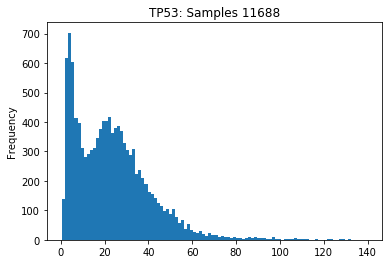

In [15]:
gene = 'TP53'
#gene = 'PTEN'
title = '{}: Samples {}'.format(gene, len(gt.loc[gene]))
#gtt[gene].iplot(kind='hist', title=title, yTitle='counts', xTitle='Expression (TPM)', bins=100)
gt.loc[gene].iplot(kind='hist', title=title, yTitle='counts', xTitle='Expression (TPM)', bins=100)
gt.loc[gene].plot(kind='hist', title=title, bins=100)

In [16]:
print(plotly.__version__)
print(cufflinks.__version__)
#print(ff.create_distplot.__doc__)
gene_list = ['TP53', 'PTEN', 'KRAS', 'ERBB2']
fig = ff.create_distplot([gt.loc[g] for g in gene_list], gene_list)
iplot(fig)

3.7.0
0.14.6


In [41]:
# by tissue types
gene = 'TP53'
data_lists = []
labels = []
gs.head()
for tissue in sorted(tissue_types, reverse=True):
    samples = gs[gs['SMTS'] == tissue]['SAMPID'].to_list()
    #print(tissue)
    #print(len(samples))
    gt_samples = [s for s in samples if s in gt.columns]
    if len(gt_samples) > 20:
        dt = gt.loc[gene][samples].dropna()
        if not dt.empty:
            data_lists.append(dt)
            labels.append('{}({}) ~ {}'.format(tissue, len(samples), round(dt.median(), 1)))
    else:
        print('Only {} samples for "{}"'.format(len(gt_samples), tissue))
    
fig = ff.create_distplot(data_lists[:14], labels[:14], show_hist=False, show_rug=False, show_curve=True)  # curve_type='normal')
fig2 = ff.create_distplot(data_lists[14:], labels[14:], show_hist=False, show_rug=False, show_curve=True)
fig2.layout.update(title=gene)
#iplot(fig)
iplot(fig2)

Only 7 samples for "Fallopian Tube"
Only 11 samples for "Cervix Uteri"
Only 0 samples for "Bone Marrow"
Only 11 samples for "Bladder"


In [43]:
subplots = plotly.tools.make_subplots(rows=2, cols=1)
dir(subplots)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_animation_duration_validator',
 '_animation_easing_validator',
 '_batch_layout_edits',
 '_batch_trace_edits',
 '_bracket_re',
 '_build_dispatch_plan',
 '_build_update_params_from_batch',
 '_config',
 '_data',
 '_data_defaults',
 '_data_objs',
 '_data_validator',
 '_dispatch_layout_change_callbacks',
 '_dispatch_trace_change_callbacks',
 '_frame_objs',
 '_frames_validator',
 '_get_child_prop_defaults',
 '_get_child_props',
 '_grid_ref',
 '_grid_str',
 '_in_batch_mode',
 '_index_is',
 '_init_child_props',
 '_initialize_layout_template',
 '_is_dict_list',
 '_is_